# EGM algorithm for the firms problem with 2 endogenous states

## Setup - import packages

In [1]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from SSJ_ext.het_block import het
import EGM_firms_problem_dyn_K_L as EGM_utils # helper functions for solving DP problem 
import SSJ_ext.utils as utils 
import SSJ_ext.jacobian as jac # to calculate jacobians for IRFs

from consav import golden_section_search
from numba import njit, prange
from consav import linear_interp
import time

## The problem
The following code solves the dynamic programming problem:
\begin{gather}
V_{t}\left(\ell_{t-1},k_{t-1},z_{t}\right)=\max_{k_{t},\ell_{t},v_{t},I_{t}}\pi\left(\ell_{t-1},k_{t-1},\ell_{t},k_{t},z_{t}\right)+\beta_{t+1}E_{t}V_{t}\left(\ell_{t},k_{t},z_{t+1}\right)
\end{gather}
subject to the constraints:
\begin{gather}
y_{t}=z_{t}k_{t}^{\alpha}\ell_{t}^{\alpha^{\ell}} \\
\pi\left(\ell_{t-1},k_{t-1},\ell_{t},k_{t},z_{t}\right)=p_{t}y_{t}-p_{t}^{I}I_{t}-\frac{\phi^{k}}{2}\left(\frac{k_{t}}{k_{t-1}}-1\right)^{2}k_{t-1}-w_{t}\ell_{t}-\frac{\phi^{\ell}}{2}\left(\frac{\ell_{t}}{\ell_{t-1}}-1\right)^{2}\ell_{t-1}-\kappa v_{t} \\
k_{t}=(1-\delta^{k})k_{t-1}+I_{t} \\
\ell_{t}=(1-\delta^{\ell})\ell_{t-1}+v_{t}m_{t}
\end{gather}
The first-order conditions used in the endogenous grid method are:
\begin{gather}
\frac{\kappa}{m_{t}}+w_{t}+\phi^{\ell}\left(\frac{\ell_{t}}{\ell_{t-1}}-1\right)=\alpha^{\ell}z_{t}k_{t}^{\alpha^{k}}\ell_{t}^{\alpha^{\ell}-1}+\beta_{t+1}E_{t}\frac{\partial V_{t}\left(\ell_{t},k_{t},z_{t+1}\right)}{\partial\ell_{t}} \\
\frac{\partial V_{t}\left(\ell_{t},k_{t},z_{t+1}\right)}{\partial\ell_{t}}=(1-\delta^{\ell})\frac{\kappa}{m_{t+1}}+\frac{\phi^{\ell}}{2}\left(\left(\frac{\ell_{t+1}}{\ell_{t}}\right)^{2}-1\right) \\
p_{t}^{I}+\phi^{k}\left(\frac{k_{t}}{k_{t-1}}-1\right)=\alpha^{k}z_{t}k_{t}^{\alpha^{k}-1}\ell_{t}^{\alpha^{\ell}}+\beta_{t+1}E_{t}\frac{\partial V_{t}\left(\ell_{t},k_{t},z_{t+1}\right)}{\partial k_{t}} \\
\frac{\partial V_{t}\left(\ell_{t},k_{t},z_{t+1}\right)}{\partial k_{t}}=(1-\delta^{k})p_{t+1}^{I}+\frac{\phi^{k}}{2}\left(\left(\frac{k_{t+1}}{k_{t}}\right)^{2}-1\right)
\end{gather}

## EGM backstep code

In [2]:
@njit
def calc_flowprofit(k, l, z, k_grid, l_grid, alphaK, alphaL, p, pI, w, deltaL, deltaK, m, kappaV, phi_K, phi_L):
    adj_cost_K = EGM_utils.get_phi_derive(k, k_grid, phi_K)[0]
    adj_cost_L = EGM_utils.get_phi_derive(l, l_grid, phi_L)[0]
    inv = k - (1-deltaK) * k_grid   
    v = (l - (1-deltaL) * l_grid)/m
    Y = z * k**alphaK * l**alphaL
    return p * Y - w * l - pI * inv - v*kappaV - adj_cost_K - adj_cost_L


@het(exogenous='Pi_p', policy=['l', 'k'], backward=['cont_val_k', 'cont_val_l'])
def Firm_backwards(cont_val_k_p, cont_val_l_p, Pi_p, k_grid, l_grid, z_grid, alphaK, alphaL, p, pI, deltaK, phi_K, kappaV, m, phi_L, r, w, deltaL):
    z = z_grid
    beta = 1/(1+r)
    
    # adjustment costs 
    phi_K_prior = EGM_utils.get_phi_derive(k_grid[:, np.newaxis], k_grid[np.newaxis, :], phi_K)[1]
    phi_l_prior = EGM_utils.get_phi_derive(l_grid[:, np.newaxis], l_grid[np.newaxis, :], phi_L)[1]

    # take expectation over productivity shocks using markov matrix Pi_p 
    E_L_costs = EGM_utils.matrix_times_first_dim(Pi_p, cont_val_l_p)
    E_K_costs = EGM_utils.matrix_times_first_dim(Pi_p, cont_val_k_p)
    
    # find optimal labor input using interpolation on dynamic FOC 
    rhs_l = alphaL * p * z[:, np.newaxis, np.newaxis] * k_grid[np.newaxis, np.newaxis, :]**(alphaK) * l_grid[np.newaxis, :, np.newaxis]**(alphaL-1) + E_L_costs 
    lhs_l = kappaV/m + w + phi_l_prior
    i, pi = EGM_utils.lhs_equals_rhs_interpolate(np.swapaxes(rhs_l,1,2), lhs_l) # this interpolates along last axis so need to swaps axes 
    l_k_grid = np.swapaxes(utils.apply_coord(i, pi, l_grid),1,2) # l associated with l_grid last period and k_grid this period   
    

    # find optimal capital using interpolation on dynamic FOC using optimal labor input from above 
    rhs = alphaK * p * z[:, np.newaxis, np.newaxis] * k_grid[np.newaxis, np.newaxis, :]**(alphaK-1) * l_k_grid**alphaL + E_K_costs 
    lhs = pI + phi_K_prior
    i, pi = EGM_utils.lhs_equals_rhs_interpolate(rhs, lhs)
    k = utils.apply_coord(i, pi, k_grid)  
    l = utils.apply_coord(i, pi, l_k_grid) 
    
    # calculate adjustment costs and continuation value for further backwards iteration 
    dphi_l = EGM_utils.get_phi_derive(l, l_grid[np.newaxis, :, np.newaxis], phi_L)[2]
    cont_val_l = beta * ((1-deltaL) * kappaV/m + dphi_l)
    dphi_K = EGM_utils.get_phi_derive(k, k_grid[np.newaxis, :], phi_K)[2]
    cont_val_k = beta * ((1-deltaK) * pI + dphi_K)
    
    # other output (production, profits etc.)
    y = z[:, np.newaxis, np.newaxis] * k**alphaK * l**alphaL 
    inv = k - (1-deltaK) * k_grid[np.newaxis, np.newaxis, :]
    profit = calc_flowprofit(k, l, z[:, np.newaxis, np.newaxis], k_grid[np.newaxis, np.newaxis, :], l_grid[np.newaxis,:, np.newaxis], alphaK, alphaL, p, pI, w, deltaL, deltaK, m, kappaV, phi_K, phi_L)
  
    return k, l, y, inv, cont_val_k, cont_val_l, profit


## Choose parameters and solve steady state

In [3]:
# parameters 
pars = {'alphaK' : 0.3, 'alphaL' : 0.4, 'p' : 1, 'pI' : 1.2, 'deltaK' : 0.01, 'phi_K' : 2, 'r' : 0.03, 'w' : 0.6,
        'm' : 0.5, 'kappaV' : 0.05 * 0.6 / 0.5, 'phi_L' : 0.3, 'deltaL' : 0.1}

# grid for kapital and labor 
k_grid = 1 + utils.agrid(amax=40, n=70)
l_grid = 0.1  + utils.agrid(amax=20, n=40)

# grid for idiosynchratic productivty
# no heterogeighty for now to compare with jac solution (see below) so set variance to 0 (1e-06)
rho, sigma, nZ = 0.9, 1e-06, 2

# starting values for backwards iteration 
cont_val_l = np.zeros([nZ, l_grid.size, k_grid.size])
cont_val_l[:,:,:] = ((1-pars['deltaL']) * pars['kappaV']/pars['m']) / (1+pars['r'])
cont_val_k = np.zeros([nZ, l_grid.size, k_grid.size])
cont_val_k[:,:,:] = ((1-pars['deltaK']) * pars['pI']) / (1+pars['r'])

pars.update({'k_grid':k_grid, 'l_grid':l_grid, 'rho':rho, 'sigma':sigma, 'nZ':nZ,
            'cont_val_l':cont_val_l, 'cont_val_k':cont_val_k})

# iterate until steady state is reached 
Firm_prob = Firm_backwards.attach_hetinput(EGM_utils.HET_add_ons)
t = time.time()
ss = Firm_prob.ss(**pars, accelerated_it = False, noisy=True)
elapsed_EGM = time.time() - t

print('steady-state labor and capital' , ss['L'], ss['K'])
print(f'Elapsed time with EGM:  {1000*round(elapsed_EGM,2)}ms')

Iteration: 0
Iteration: 100
Max error: {'l': 3.2139473304937383e-09, 'k': 5.9547424768879864e-08}
Converged after : 161 iterations
steady-state labor and capital 2.3691746879075035 23.41892140622153
Elapsed time with EGM:  3880.0ms


## IRF to announced price shock 

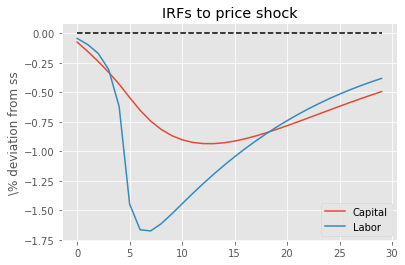

In [4]:
Time = 300     
# ttt = np.arange(0,Time)
ann = 5
dp = np.zeros(Time)
dp[ann:] = - 0.01  * 0.9**(np.arange(Time-ann))
J      = Firm_prob.jac(ss, Time, ['p'])  # get jacobian    

dK = J['K']['p'] @ dp * 100 / ss['K']
dL = J['L']['p'] @ dp * 100 / ss['L']

plt.plot(dK[:30], label='Capital')
plt.plot(dL[:30], label='Labor')
plt.plot(np.zeros(30), color = 'black', linestyle = '--')
plt.title('IRFs to price shock')
plt.ylabel(r'\% deviation from ss')
plt.legend()
plt.show() 

## Comparison

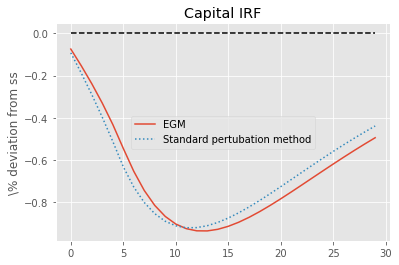

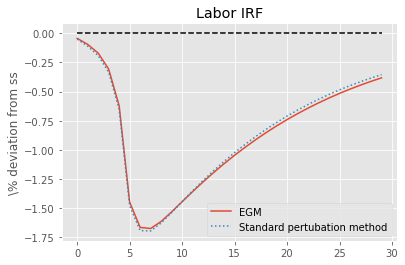

In [5]:
# Since there is no heterogeneity in the above model we can compare the solution to the one obtained 
# from a simple model solved using either standard pertubation methods (dynare etc.) or full non-linear solution
# the two should be identical (results might depend on chosen grids though)

from solved_block import solved

# define block with equations
@solved(unknowns=['K', 'L'], targets=['K_res', 'L_res'])
def firm(alphaK, alphaL, p, pI, Z, phi_K, K, L, phi_L, kappaV, deltaL, m, r, w, deltaK):
    beta = 1/(1+r)
    phi_L_prior  = phi_L  * (L/L(-1)-1)
    phi_L_p  = phi_L /2 * ((L(+1)/L)**2-1)  
    L_res = alphaL*p*Z*K**(alphaK)*L**(alphaL-1) + beta * ((1-deltaL)*kappaV/m(+1) + phi_L_p) - (w + kappaV/m + phi_L_prior)
    
    phi_K_prior  = phi_K * (K/K(-1)-1)
    phi_K_p  = phi_K /2 * ((K(+1)/K)**2-1)  
    I = K - (1-deltaK) * K(-1)
    K_res = alphaK*p*Z*K**(alphaK-1)*L**alphaL + beta * ((1-deltaK)*pI + phi_K_p) - (pI + phi_K_prior)
    Y = Z * K**alphaK * L**alphaL
    return L_res, K_res, Y, I 

Kss, Lss = ss['K'],ss['L']

ss.update({'Z':1})

J_simple =   firm.jac(ss, Time, ['p'])     

dY_simple = J_simple['Y']['p'] @ dp * 100 / ss['Y']
dK_simple = J_simple['K']['p'] @ dp * 100 / ss['K']
dL_simple   = J_simple['L']['p'] @ dp * 100 / ss['L']

plt.plot(dK[:30], label='EGM')
plt.plot(dK_simple[:30], ':', label='Standard pertubation method')
plt.plot(np.zeros(30), color = 'black', linestyle = '--')
plt.title('Capital IRF')
plt.ylabel(r'\% deviation from ss')
plt.legend()
plt.show() 

plt.plot(dL[:30], label='EGM')
plt.plot(dL_simple[:30], ':', label='Standard pertubation method')
plt.plot(np.zeros(30), color = 'black', linestyle = '--')
plt.title('Labor IRF')
plt.ylabel(r'\% deviation from ss')
plt.legend()
plt.show() 

# With positive-profit constraint 

In [8]:
from quantecon.optimize import nelder_mead

@njit
def profitfunc(x, jz, jk, jl, z, k_grid, l_grid, alphaK, alphaL, p, pI, w, phi_K, phi_L, deltaK, deltaL, m, kappaV, v_p, beta, Pi_p):
    k_g, l_g = x 
    flowprofit = calc_flowprofit(k_g, l_g, z[jz], k_grid[jk], l_grid[jl], alphaK, alphaL, p, pI, w, deltaL, deltaK, m, kappaV, phi_K, phi_L)
    w = 0 
    for j in range(len(z)):
        w += Pi_p[jz, j] * linear_interp.interp_2d(l_grid, k_grid, v_p[j,:,:], l_g, k_g)  
    
    # penalty to enforce profit constraint 
    pen = 0 
    #if flowprofit < 1e-07:
    #    pen = 10 + abs(flowprofit) * 500  # penalty should be continuous in flowprofit to help optimizer 
    profit = flowprofit + beta * w - pen
    return profit 

def endo_con(k, l, args):
    flowprofit = calc_flowprofit(k, l, z[jz], k_grid[jk], l_grid[jl], alphaK, alphaL, p, pI, w, deltaL, deltaK, m, kappaV, phi_K, phi_L)
    if flowprofit <= 0:
        return True
    else:
        return False

@njit(parallel=True)
def max_bellman(k, l, v, z, k_grid, l_grid, alphaK, alphaL, p, pI, w, phi_K, phi_L, deltaK, deltaL, m, kappaV, v_p, beta, Pi_p):
    kmax = 1.5 * max(k_grid)
    lmax = 1.5 * max(l_grid)
    kmin = 0.01 * min(k_grid)
    lmin = 0.01 * min(l_grid)
    # check profit constraint
    for jz in prange(len(z)):
        for jk in range(len(k_grid)):
            for jl in range(len(l_grid)):
                args = (jz, jk, jl, z, k_grid, l_grid, alphaK, alphaL, p, pI, w, phi_K, phi_L, deltaK, deltaL, m, kappaV, v_p, beta, Pi_p)
                results = nelder_mead(profitfunc, np.array([k_grid[jk], l_grid[jl]]), bounds = np.array([[kmin,kmax],[lmin,lmax]]), args=args)
                k[jz,jl,jk] = results.x[0]
                l[jz,jl,jk] = results.x[1]
                v[jz,jl,jk] = results.fun
    return k, l, v
    
@het(exogenous='Pi_p', policy=['k', 'l'], backward=['v'])
def Firm_backwards_VFI(v_p, Pi_p, k_grid, l_grid, z_grid, alphaK, alphaL, p, pI, deltaK, phi_K, kappaV, m, phi_L, r, w, deltaL):
    z = z_grid
    beta = 1/(1+r)
    
    v = np.zeros_like(v_p) 
    k = np.zeros_like(v_p) 
    l = np.zeros_like(v_p) 
    k, l, v = max_bellman(k, l, v, z, k_grid, l_grid, alphaK, alphaL, p, pI, w, phi_K, phi_L, deltaK, deltaL, m, kappaV, v_p, beta, Pi_p)

    # other output (production, profits etc.)
    y = z[:, np.newaxis, np.newaxis] * k**alphaK * l**alphaL 
    inv = k - (1-deltaK) * k_grid[np.newaxis, np.newaxis, :]
    profit = calc_flowprofit(k, l, z[:, np.newaxis, np.newaxis], k_grid[np.newaxis, np.newaxis, :], l_grid[np.newaxis,:, np.newaxis], alphaK, alphaL, p, pI, w, deltaL, deltaK, m, kappaV, phi_K, phi_L)
    #plt.plot(k[0,:,20])
    #plt.show() 
    return k, l, y, inv, cont_val_k, cont_val_l, v, profit


In [ ]:
pars['v'] = ss['profit']
Firm_prob_VFI = Firm_backwards_VFI.attach_hetinput(EGM_utils.HET_add_ons)
t = time.time()
ss_VFI = Firm_prob_VFI.ss(**pars, accelerated_it = False, noisy=True)
elapsed_VFI = time.time() - t

print('steady-state labor and capital' , ss_profitcon['L'], ss_profitcon['K'])
print(f'Elapsed time with VFI:  {1000*round(elapsed_VFI,2)}ms')

Iteration: 0
Iteration: 100
Max error: {'k': 0.00021374714083677304, 'l': 0.0011232028100915947}
Iteration: 200
Max error: {'k': 8.873234944672959e-05, 'l': 3.4754664701708293e-09}


In [ ]:
midp = round(len(ss['k'][0,:,0]) / 2)
plt.plot(ss['k'][0,midp,:])
plt.plot(ss_VFI['k'][0,midp,:], '--')
plt.show()

plt.plot(ss['l'][0,midp,:])
plt.plot(ss_VFI['l'][0,midp,:], '--')
plt.show()

plt.plot(ss['k'][0,:,midp])
plt.plot(ss_VFI['k'][0,:,midp], '--')
plt.show()

plt.plot(ss['l'][0,:,midp])
plt.plot(ss_VFI['l'][0,:,midp], '--')
plt.show()


plt.plot(ss['profit'][0,midp,:])
plt.plot(ss_VFI['profit'][0,midp,:], '--')
plt.show()


In [ ]:
J_VFI = Firm_prob_VFI.jac(ss_VFI, Time, ['p'])  # get jacobian    

dK_VFI = J_VFI['K']['p'] @ dp * 100 / ss_VFI['K']
dL_VFI = J_VFI['L']['p'] @ dp * 100 / ss_VFI['L']

plt.plot(dK_VFI[:30], label='VFI')
plt.plot(dK_simple[:30], ':', label='Standard pertubation method')
plt.plot(np.zeros(30), color = 'black', linestyle = '--')
plt.title('Capital IRF')
plt.ylabel(r'\% deviation from ss')
plt.legend()
plt.show() 

plt.plot(dL_VFI[:30], label='VFI')
plt.plot(dL_simple[:30], ':', label='Standard pertubation method')
plt.plot(np.zeros(30), color = 'black', linestyle = '--')
plt.title('Labor IRF')
plt.ylabel(r'\% deviation from ss')
plt.legend()
plt.show() 